In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from utils import imread, showMatches
from detectBlobs import detectBlobs
from drawBlobs import drawBlobs
from skimage.color import rgb2gray
from scipy.ndimage.filters import convolve
from compute_sift import compute_sift
from computeMatches import computeMatches
from mergeImages import mergeImages
from ransac import ransac
import sys
%matplotlib inline

/home/ec2-user/anaconda3/envs/python2/lib/python2.7/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}


In [5]:
import numpy as np
from skimage.color import rgb2gray
from scipy.ndimage.filters import convolve
import sys

def laplacian_of_gaussian_filter11(sigma):
    cutoff = sys.float_info.epsilon
    half_size = (np.round(4*sigma) + 1)/2 if np.round(4*sigma) % 2 == 0 else np.round(4*sigma)/2
    x, y = np.meshgrid(np.arange(-half_size, half_size+1), np.arange(-half_size, half_size+1))
    
    exp_term=np.exp(-(np.power(x, 2) + np.power(y,2)) / 2*np.power(sigma, 2))
    exp_term[exp_term < sys.float_info.epsilon * exp_term.max()] = 0
    exp_term = exp_term if exp_term.sum() == 0 else exp_term/exp_term.sum() 
    kernel = -((np.power(x, 2) + np.power(y,2) - 2*np.power(sigma, 2)) / np.power(sigma, 2))
    kernel *= exp_term 
    kernel -= kernel.mean()
    return kernel

def create_scale_space(gray_image, sigma_scale_factor, initial_sigma, level):
    h,w = np.shape(gray_image)
    scale_space = np.zeros((h,w,level))
    sigma = [0]*(level+1)
    sigma[0] = initial_sigma
    for i in range(0,level):
        filter = laplacian_of_gaussian_filter11(sigma[i])
        print ("Convolving for level = {}".format(i))
        scale_space[:,:,i] = np.square(convolve(gray_image, filter))
        sigma[i+1] = sigma[i]*sigma_scale_factor
    return scale_space, sigma

def max_scaled_spaces(scale_spaces, i, j, l1, l2):
    h, w = scale_spaces[:, :, 0].shape
    search_over = [(0, 1), (0, -1), (1, 1), (1, -1), (-1, 1), (-1, -1), (1, 0), (-1, 0)]
    flag = True
    for _i, _j in search_over:
        if (i+_i in range(h)) and (j+_j in range(w)):
            if scale_spaces[i+_i, j+_j, l2] >= scale_spaces[i, j, l1]:
                flag = False    
    return flag

def non_max_suppression_blobs(scale_spaces, scaling, sigma, level_, cutoff=0.003):
    scale_spaces_max = scale_spaces.copy()
    h, w = scale_spaces_max[:, :, 0].shape
    kernel = [int(np.ceil(s)) for s in sigma]
    blob_location = []
    for le in range(0, level_):
        print ("Iterating for Level={}".format(le))
        curr = kernel[le]
        scale_spaces_max[-curr:, -curr:, le] = 0
        scale_spaces_max[:curr, :curr, le] = 0
        for i in range(curr+1, (h - curr - 1)):
            for j in range(curr+1, (w - curr - 1)):
                if scale_spaces[i, j, le] < cutoff:
                    continue
                curr_flag = max_scaled_spaces(scale_spaces, i, j, le, le)
                lower_flag = (le > 0) and scale_spaces[i, j, le-1] < scale_spaces[i, j, le] and max_scaled_spaces(scale_spaces, i, j, le, le-1)
                upper_flag = (le < level_-1) and scale_spaces[i, j, le+1] < scale_spaces[i, j, le]  and max_scaled_spaces(scale_spaces, i, j, le, le+1) 
                if curr_flag and lower_flag and upper_flag:
                    blob_location.append([i, j, le, scale_spaces[i, j, le]])
                    scale_spaces_max[i, j, le] = 1   
    blobs = np.zeros((len(blob_location), 5))
    i = 0
    for item in blob_location:
        x, y = item[0], item[1]
        radius = sigma[item[2]]
        score = item[3]
        blobs[i] = [y, x, radius, -1, score] #(x, y, radius, angle, score)
        i+=1
    return blobs

def detectBlobs(im, param={}):
    #Default Params
    default_cutoff, default_sigma, default_level, default_scaling = 0.001, 1.2, 13, np.sqrt(1.8)
    cutoff = param.get("cutoff") if param.get("cutoff") is not None else default_cutoff
    sigma_seed = param.get("sigma_seed") if param.get("sigma_seed") is not None else default_sigma
    level = param.get("level") if param.get("level") is not None else default_level
    scaling = param.get("scaling") if param.get("scaling") is not None else default_scaling
    processed_im = rgb2gray(rgb2gray(im))
    scale_space, sigma = create_scale_space(processed_im, scaling, sigma_seed, level)
    blobs = non_max_suppression_blobs(scale_space, scaling, sigma, level, cutoff)
    return blobs

Convolving for level = 0
Convolving for level = 1
Convolving for level = 2
Convolving for level = 3
Convolving for level = 4
Convolving for level = 5
Convolving for level = 6
Convolving for level = 7
Convolving for level = 8
Convolving for level = 9
Convolving for level = 10
Convolving for level = 11
Convolving for level = 12
Iterating for Level=0
Iterating for Level=1
Iterating for Level=2
Iterating for Level=3
Iterating for Level=4
Iterating for Level=5
Iterating for Level=6
Iterating for Level=7
Iterating for Level=8
Iterating for Level=9
Iterating for Level=10
Iterating for Level=11
Iterating for Level=12


<Figure size 432x288 with 0 Axes>

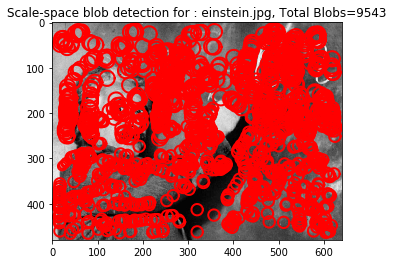

In [6]:
dataDir = os.path.join('..', 'data', 'blobs')
testExamples = ['butterfly.jpg', 'einstein.jpg', 'fishes.jpg', 'sunflowers.jpg'] 
example = 'einstein.jpg'
#for example in testExamples:
cutoff = 0.005
#if example == 'sunflowers.jpg': cutoff = .0005
plt.clf() 
im = imread(os.path.join(dataDir, example))
blobs = detectBlobs11(im, {'cutoff': cutoff, 'level': 13})
drawBlobs(im, blobs, example, 1250)

In [ ]:
dataDir = os.path.join('..', 'data', 'blobs')
testExamples = ['butterfly.jpg', 'einstein.jpg', 'fishes.jpg', 'sunflowers.jpg'] 
for example in testExamples:
    cutoff = 0.001
    if example == 'sunflowers.jpg': cutoff = .0005
    plt.clf() 
    im = imread(os.path.join(dataDir, example))
    blobs = detectBlobs(im, {'cutoff': cutoff, 'level': 14})
    drawBlobs(im, blobs, example, 1250)